# Importance sampling: toy example with parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(32768, 3, 1, 1), ratio=0.5):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size) + 0.2 # to make light gray
    image_batch[idx] = 1 - 0.2 # to make light gray 
    return image_batch

The dataset class

In [4]:
class BlackWhiteDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, weight_network):
        self.dataset = random_image_data()
        
        self.weight_network = weight_network

    def __len__(self):
        return len(self.dataset)
    
    def accept_sample(self, weight_network, img):
        # Returns True if the image is accepted, False if rejected
        weight = weight_network(img)
        return bool(list(torch.utils.data.sampler.WeightedRandomSampler([1-weight, weight], 1))[0])
    
    def __getitem__(self, idx):
        # Random permutation on the dataset order (is this equivalent to uniform sampling?)
        all_idx = torch.randperm(len(dataset))
        
        # Loop through the samples and return once accepted
        for i in all_idx:
            accept = self.accept_sample(self.weight_network, self.dataset[i])
            if accept:
                return self.dataset[i]

The weight network with parameters

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
        self.fc1.weight.data.fill_(0.5) # This as initialization because when the weights are too small
        self.fc2.weight.data.fill_(0.5) # no images are sampled

    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

weight_network = Net()

In [6]:
dataset = BlackWhiteDataset(weight_network)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [7]:
example_img = torch.cat((torch.Tensor([0.2, 0.2, 0.2]), torch.Tensor([0.8, 0.8, 0.8])))
w = weight_network(example_img)
print(w)

tensor([[0.7313],
        [0.8102]], grad_fn=<SigmoidBackward>)


Training loop with MSE

In [8]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(weight_network.parameters(), lr=0.01)

In [9]:
for i, data in enumerate(dataloader):
    labels = data.mean(1).view(-1, 1)
    
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = weight_network(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    if i % 50 == 0:
        print('step', i, 'loss: ', loss.item())
#         print('outputs:', outputs[0].item(), 'labels:', labels[0].item())
#         print()

step 0 loss:  0.13680525124073029
step 50 loss:  0.08545710891485214
step 100 loss:  0.052934058010578156
step 150 loss:  0.014898096211254597
step 200 loss:  0.00482331495732069
step 250 loss:  0.002038559876382351
step 300 loss:  0.0011581454891711473
step 350 loss:  0.0003164297086186707
step 400 loss:  0.0001686696632532403
step 450 loss:  6.612746074097231e-05
step 500 loss:  3.325877332827076e-05


With Helge's objective function

In [10]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
for i, data in enumerate(dataloader):
#     labels = data.mean(1).view(-1, 1)

    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = weight_network(data)
    
    # Ground truth:
    ground_truth = data.mean(1).view(-1, 1) 
    
    loss = ((1-outputs.detach()) * (outputs/outputs.detach()).view(-1, 1)).sum()
    
    loss.backward()
    optimizer.step()

    # print statistics
    if i % 50 == 0:
        
        w = weight_network(example_img)
        print('step', i, 'loss: ', loss.item())
        print('outputs:', w[0].item(), w[1].item(), 'ground_truth', example_img[0].item(), example_img[3].item())
        print()

step 0 loss:  19.333093643188477
outputs: 0.20418091118335724 0.775668203830719 ground_truth 0.20000000298023224 0.800000011920929

step 50 loss:  61.836910247802734
outputs: 0.03269349783658981 0.03269349783658981 ground_truth 0.20000000298023224 0.800000011920929

step 100 loss:  63.47189712524414
outputs: 0.008053789846599102 0.008053789846599102 ground_truth 0.20000000298023224 0.800000011920929

step 150 loss:  63.82422637939453
outputs: 0.0026917282957583666 0.0026917282957583666 ground_truth 0.20000000298023224 0.800000011920929

step 200 loss:  63.931575775146484
outputs: 0.0010503757512196898 0.0010503757512196898 ground_truth 0.20000000298023224 0.800000011920929

step 250 loss:  63.97072982788086
outputs: 0.0004499885835684836 0.0004499885835684836 ground_truth 0.20000000298023224 0.800000011920929

step 300 loss:  63.986663818359375
outputs: 0.0002052288909908384 0.0002052288909908384 ground_truth 0.20000000298023224 0.800000011920929

step 350 loss:  63.993648529052734
out

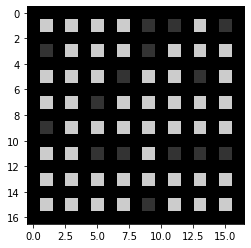

In [11]:
visualize_img_batch(data)